# Hybrid ResNet-50 + ViT Architecture with CLAHE optimization

In [10]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, LayerNormalization, MultiHeadAttention, Dropout, Add, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import precision_recall_curve, auc
import tensorflow_addons as tfa

In [3]:
BASE_DIR = "./dataset_balanced/"
CSV_PATH = os.path.join(BASE_DIR, "new_labels.csv")

IMAGE_DIR = os.path.join(BASE_DIR, "resized_images", "resized_images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 51382


In [4]:
# Load CSV and extract relevant columns
df = pd.read_csv(CSV_PATH)

# Column names
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
          'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
          'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Ensure the 'Path' column is used for image paths
df = df[['Path'] + labels]


df['has_label'] = df[labels].sum(axis=1)
df['has_label'] = df['has_label'].apply(lambda x: 1 if x > 0 else 0) # Binary label for presence of any disease


# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# With augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
)

# Add the 'path' column to train_df and val_df
train_df['path'] = train_df['Path'].map(IMAGE_FILES)
val_df['path'] = val_df['Path'].map(IMAGE_FILES)
val_df = val_df[val_df['has_label'] == 1]


train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=False
)

Found 41105 validated image filenames.
Found 9272 validated image filenames.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(labels), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
# --- Transformer Block ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(x, x)
    x = Add()([attention_output, inputs])

    ff_x = LayerNormalization(epsilon=1e-6)(x)
    ff_x = Dense(ff_dim, activation="gelu")(ff_x)
    ff_x = Dropout(dropout)(ff_x)
    ff_x = Dense(x.shape[-1])(ff_x)  # Use x.shape[-1] to preserve dimensions

    return Add()([x, ff_x])

# --- Hybrid ResNet-50 + ViT Model ---
def create_hybrid_model(
    input_shape=(224, 224, 3),
    num_classes=7,
    num_transformer_blocks=6,
    head_size=64,
    num_heads=8,
    ff_dim=256,
    transformer_dropout=0.1,
    mlp_units=[512],
    dropout_rate=0.1,
    projected_dim=512,
):
    # ResNet-50 backbone
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in resnet_base.layers:
        layer.trainable = False

    x = resnet_base.output
    _, h, w, c = x.shape

    # Reshape CNN features -> sequence
    patches = Reshape((h * w, c))(x)

    # Project to transformer dimension
    x = LayerNormalization(epsilon=1e-6)(patches)
    x = Dense(projected_dim)(x)

    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, transformer_dropout)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # MLP Head
    for dim in mlp_units:
        x = Dense(dim, activation="gelu")(x)
        x = Dropout(dropout_rate)(x)

    output = Dense(num_classes, activation="sigmoid")(x)

    model = Model(inputs=resnet_base.input, outputs=output)
    return model, resnet_base

# --- Create Model ---
model, base_model = create_hybrid_model(
    input_shape=(224, 224, 3),
    num_classes=len(labels),  # <-- adjust to your labels
    num_transformer_blocks=6,
    head_size=64,
    num_heads=8,
    ff_dim=256,
    transformer_dropout=0.1,
    mlp_units=[512],
    dropout_rate=0.1,
    projected_dim=512,
)

# --- Callbacks ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

checkpoint_path = "./output/thoracic_classifierV8.keras"
log_path = "./output/training_log.csv"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger(log_path, append=False)

# --- Fine-tune Top Layers ---
for layer in base_model.layers[-94:]:
    layer.trainable = True

# --- Compile Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=[
        "binary_accuracy",
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC()
    ]
)

# --- Train ---
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[lr_scheduler, checkpoint_callback, csv_logger, early_stopping]
)

Epoch 1/20
2570/2570 [==============================] - ETA: 0s - loss: 0.4148 - binary_accuracy: 0.9014 - recall_1: 0.0130 - precision_1: 0.6130 - auc_1: 0.6793
Epoch 1: val_loss improved from inf to 0.42448, saving model to ./output\thoracic_classifierV8.keras
2570/2570 [==============================] - 2348s 900ms/step - loss: 0.4148 - binary_accuracy: 0.9014 - recall_1: 0.0130 - precision_1: 0.6130 - auc_1: 0.6793 - val_loss: 0.4245 - val_binary_accuracy: 0.8939 - val_recall_1: 0.0546 - val_precision_1: 0.7781 - val_auc_1: 0.7322 - lr: 1.0000e-04
Epoch 2/20
2570/2570 [==============================] - ETA: 0s - loss: 0.3746 - binary_accuracy: 0.9052 - recall_1: 0.0509 - precision_1: 0.8675 - auc_1: 0.7583
Epoch 2: val_loss improved from 0.42448 to 0.40369, saving model to ./output\thoracic_classifierV8.keras
2570/2570 [==============================] - 2395s 932ms/step - loss: 0.3746 - binary_accuracy: 0.9052 - recall_1: 0.0509 - precision_1: 0.8675 - auc_1: 0.7583 - val_loss: 0.4

580/580 [==============================] - 74s 123ms/step


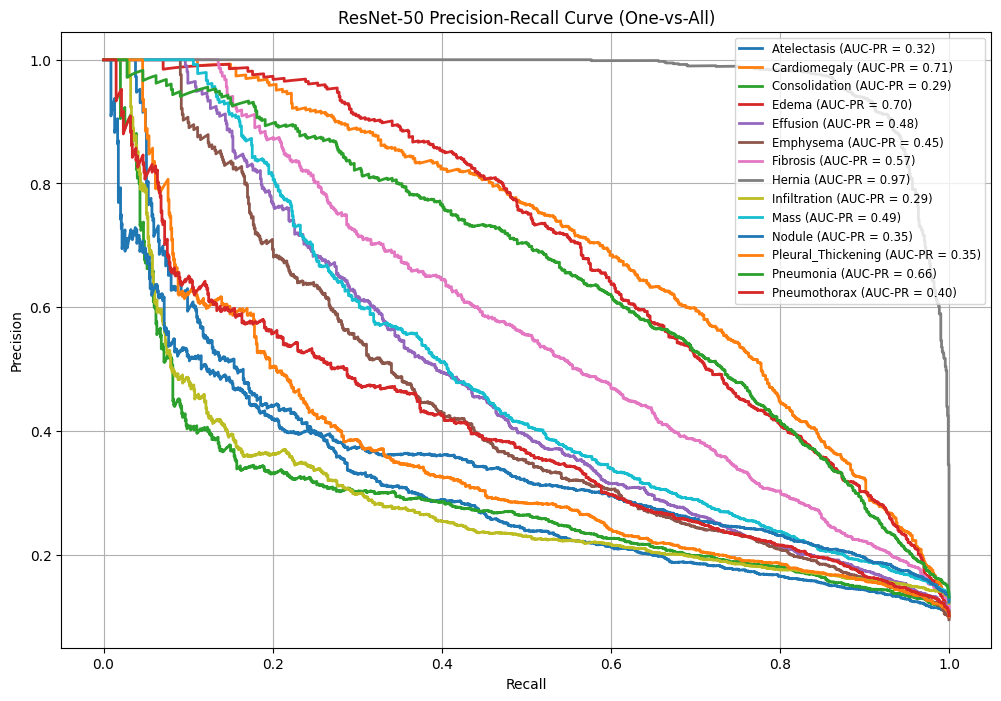

In [13]:
# True and predicted labels
y_true = val_gen.labels
y_pred = model.predict(val_gen)

# Compute Precision-Recall and AUC-PR for each class
precision = dict()
recall = dict()
auc_pr = dict()

for i in range(len(labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Plot
plt.figure(figsize=(12, 8))
for i in range(len(labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} (AUC-PR = {auc_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ResNet-50 Precision-Recall Curve (One-vs-All)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

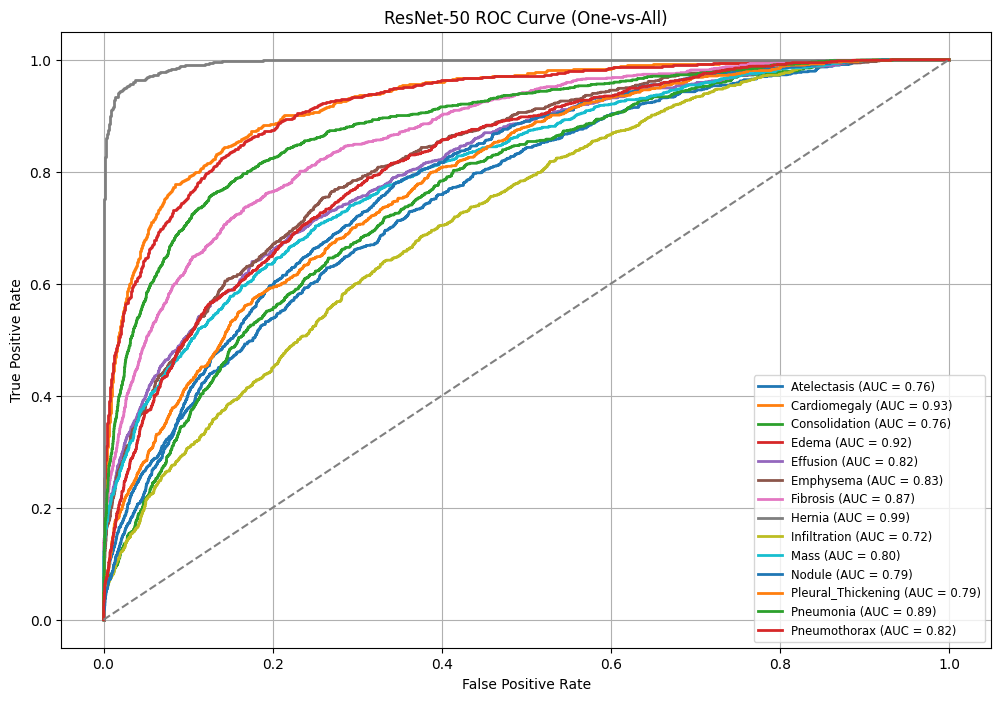

In [15]:
from sklearn.metrics import roc_curve, auc

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(12, 8))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet-50 ROC Curve (One-vs-All)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()


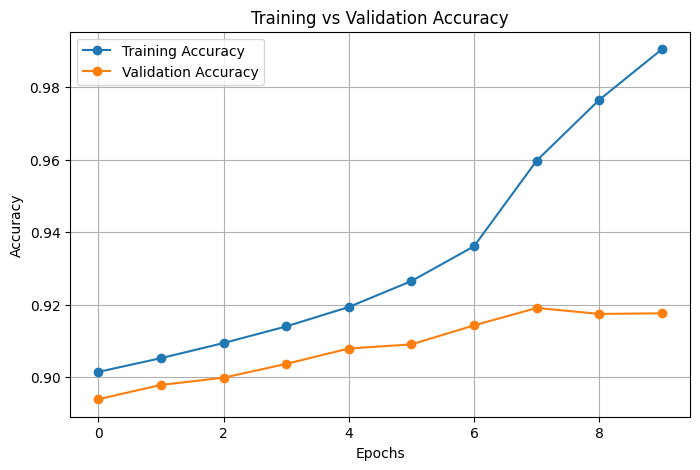

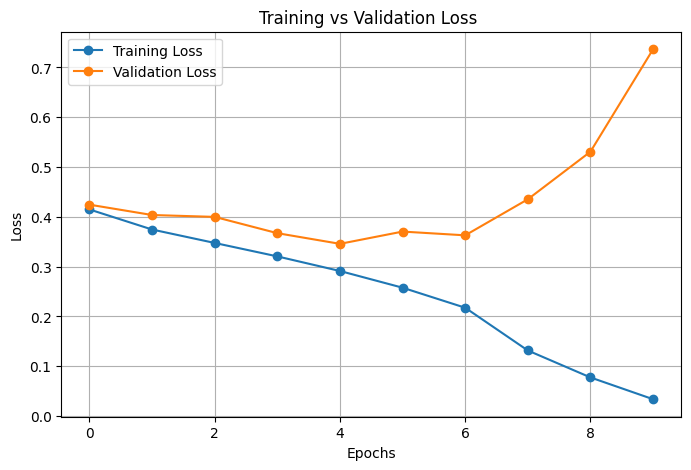

In [16]:
data = pd.read_csv(log_path)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(data['epoch'], data['binary_accuracy'], label='Training Accuracy', marker='o')
plt.plot(data['epoch'], data['val_binary_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(data['epoch'], data['loss'], label='Training Loss', marker='o')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss ')
plt.legend()
plt.grid()
plt.show()

Mean AUC: 0.83


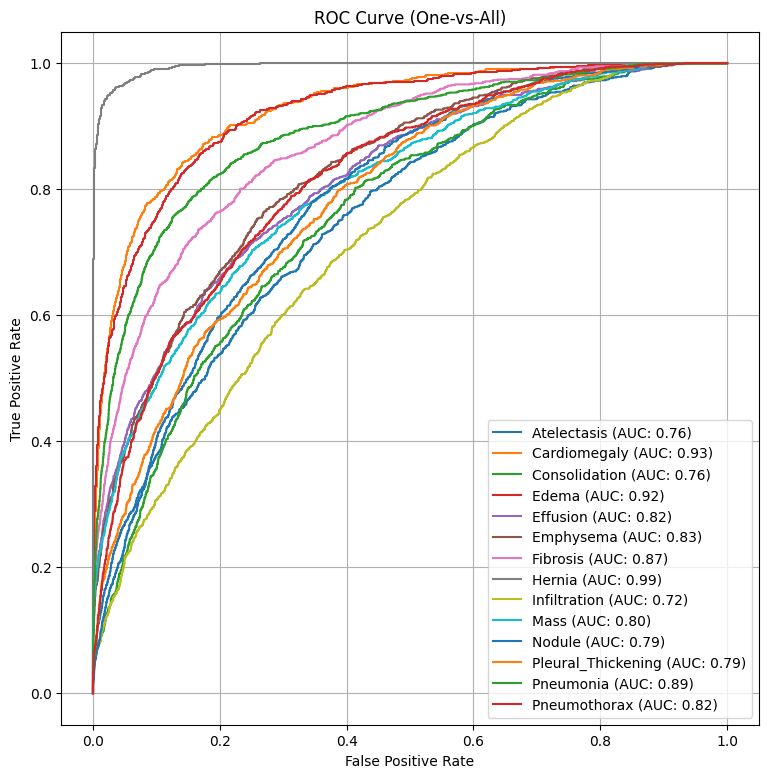

In [27]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
mean_auc = 0

# Loop through each label and calculate ROC and AUC
for idx, c_label in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_true[:, idx], y_pred[:, idx])
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc(fpr, tpr):.2f})')
    mean_auc += auc(fpr, tpr)

# Calculate mean AUC
mean_auc /= len(labels)
print(f"Mean AUC: {mean_auc:.2f}")

# Add labels and legend to the plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curve (One-vs-All)')
plt.grid(True)
plt.show()

In [17]:
model.save('thoracic_classifierV9.h5')  # Saves as HDF5 format
model.save('thoracic_classifierV9.keras')  # Saves as Keras format

## Testing the Model

1/1 [==============================] - 0s 143ms/step

Image 1 probabilities:
Atelectasis: 17.53%
Cardiomegaly: 13.04%
Consolidation: 11.40%
Edema: 8.37%
Effusion: 37.69%
Nodule: 22.54%
Pleural_Thickening: 56.11%
Pneumonia: 9.37%
Pneumothorax: 12.91%

Image 2 probabilities:
Atelectasis: 3.53%
Cardiomegaly: 4.63%
Consolidation: 0.54%
Edema: 0.57%
Effusion: 0.97%
Nodule: 1.22%
Pleural_Thickening: 1.22%
Pneumonia: 98.03%
Pneumothorax: 0.99%

Image 3 probabilities:
Atelectasis: 9.71%
Cardiomegaly: 2.91%
Consolidation: 1.07%
Edema: 0.72%
Effusion: 1.23%
Nodule: 1.28%
Pleural_Thickening: 5.09%
Pneumonia: 93.24%
Pneumothorax: 3.39%

Image 4 probabilities:
Atelectasis: 4.75%
Cardiomegaly: 77.45%
Consolidation: 3.48%
Edema: 6.66%
Effusion: 7.70%
Nodule: 1.79%
Pleural_Thickening: 6.30%
Pneumonia: 98.45%
Pneumothorax: 4.12%


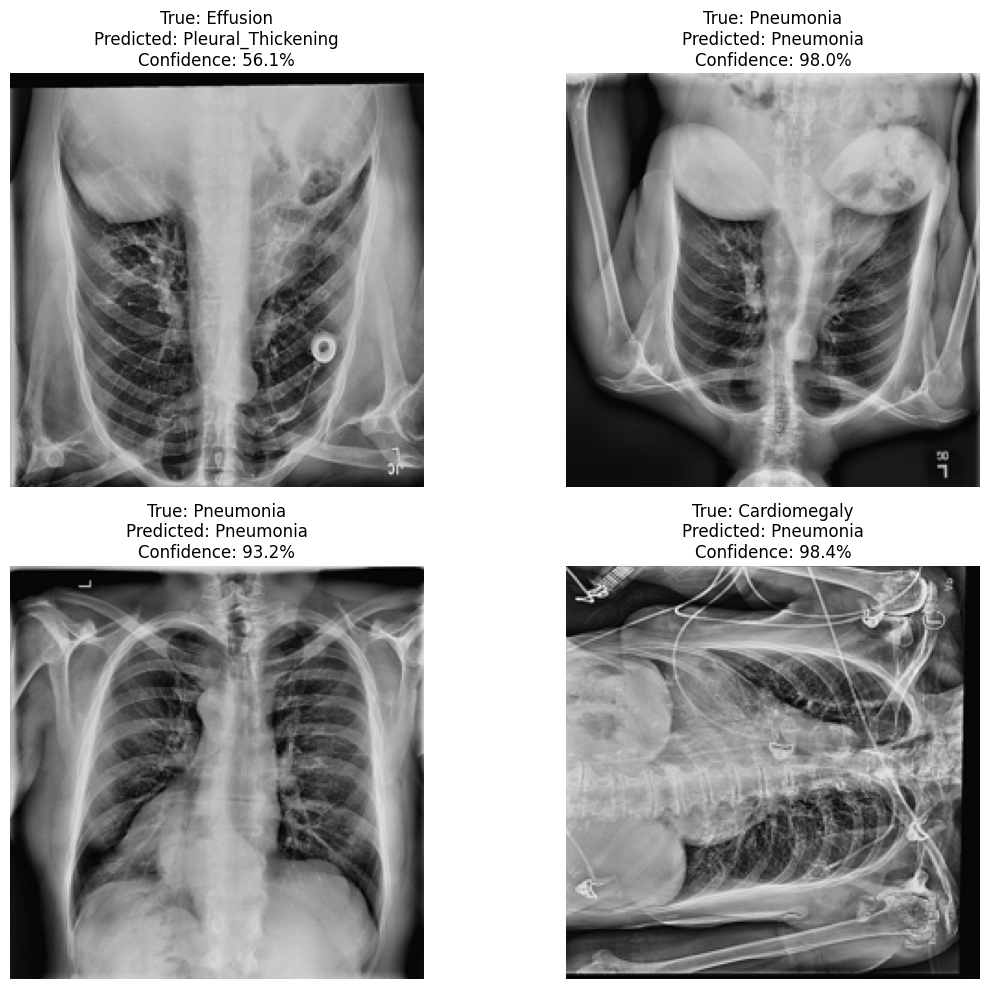

In [ ]:
# Get a batch of images and labels from the validation generator
batch_images, batch_labels = next(val_gen)

# Make predictions on the batch
batch_preds = model.predict(batch_images)

# Define disease names mapping (based on your label assignments)
disease_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
          'Pneumothorax']

# Create a figure with 2x2 grid to display 4 random images
plt.figure(figsize=(12, 10))

# Display 4 random images from the batch
for i in range(4):
    # Choose a random image from the batch
    idx = np.random.randint(len(batch_images))
    img = batch_images[idx]
    
    # Get true and predicted labels
    true_label_idx = np.argmax(batch_labels[idx])
    pred_label_idx = np.argmax(batch_preds[idx])
    
    # Get disease names
    true_disease = disease_names[true_label_idx]
    pred_disease = disease_names[pred_label_idx]
    
    # Calculate confidence percentage
    confidence = batch_preds[idx][pred_label_idx] * 100
    
    # Plot the image in a subplot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_disease}\nPredicted: {pred_disease}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    
    # Print detailed probabilities for this image
    print(f"\nImage {i+1} probabilities:")
    for j, disease in enumerate(disease_names):
        prob = batch_preds[idx][j] * 100
        print(f"{disease}: {prob:.2f}%")

plt.tight_layout()
plt.show()

In [5]:
import time

# Measure inference time
start_time = time.time()
predictions = model.predict(processed_image)
end_time = time.time()

# Calculate and print inference time
inference_time = end_time - start_time
print(f"Inference Time: {inference_time * 1000:.2f} milliseconds")

# Print the results
for idx, disease in enumerate(class_names):
    print(f"{disease}: {predictions[0][idx]:.2f}")


1/1 [==============================] - 0s 50ms/step
Inference Time: 285.85 milliseconds
Atelectasis: 0.06
Cardiomegaly: 0.94
Consolidation: 0.08
Edema: 0.01
Effusion: 0.12
Emphysema: 0.02
Fibrosis: 0.02
Hernia: 0.00
Infiltration: 0.13
Mass: 0.09
No Finding: 0.09
Nodule: 0.07
Pleural_Thickening: 0.06
Pneumonia: 0.00
Pneumothorax: 0.00
